In [1]:
import os
import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
import PIL

import shutil
from shutil import unpack_archive
from subprocess import check_output

from collections import OrderedDict

In [2]:
lfw_allnames = pd.read_csv("../dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../dataset/pairs.csv")

# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../dataset/people.csv")

# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../dataset/peopleDevTrain.csv")

In [3]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",axis=1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",axis=1)
lfw_test = lfw_test.reset_index().drop("index",axis=1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

860
872


<AxesSubplot: >

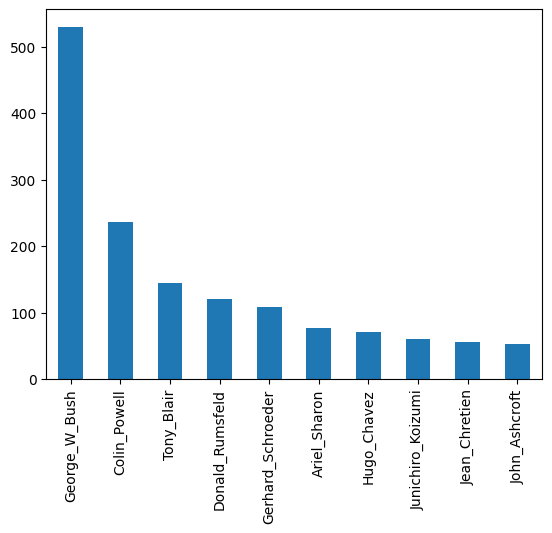

In [4]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [5]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


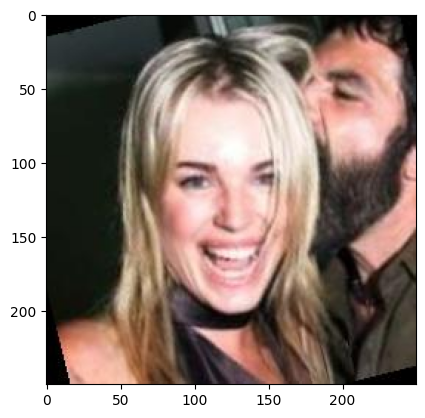

In [6]:
im = Image.open("../dataset/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

In [7]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [8]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [9]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator

In [10]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as 
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function 
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is 
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have 
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g. 
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())

# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [11]:
def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('../dataset/output/',dir_name)):
            shutil.os.mkdir(os.path.join('../dataset/output/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('../dataset/output/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('../dataset/output/',dir_name,data_type))
        path_from = os.path.join('../dataset/lfw-deepfunneled/',image)
        path_to = os.path.join('../dataset/output/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [12]:
print(os.path.join('../dataset/output/',"Bush_train/"))

../dataset/output/Bush_train/


In [13]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")


Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [14]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('../dataset/output/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 2,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('../dataset/output/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 2,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('../dataset/output/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 2,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [15]:
len(Bush_training_set)

339

In [16]:
Bush_history = Bush_classifier.fit_generator(Bush_training_set,
                                             # set steps per epoch equal to the number of training images
                                             steps_per_epoch = 678,
                                             # there is a six hour runtime limit on Kaggle Kernels, restricting the maximum epoch number
                                             epochs = 8,
                                             validation_data = Bush_val_set,
                                             validation_steps = 100)

Epoch 1/8


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_13872\1229753785.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Bush_history = Bush_classifier.fit_generator(Bush_training_set,


678/678 [==============================] - 122s 178ms/step - loss: 2.1433 - accuracy: 0.6401 - val_loss: 0.6178 - val_accuracy: 0.6882


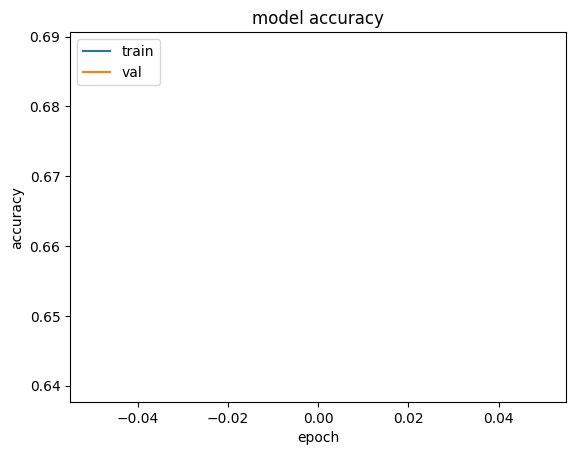

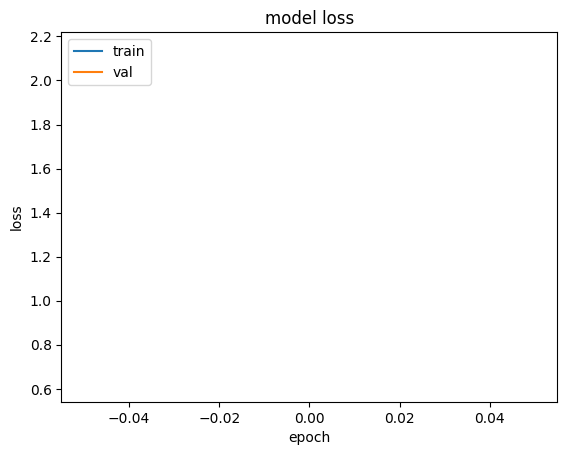

In [17]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
from keras_preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [19]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
Bush_test_names = []
# collect all file names
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# extract unique names, in order
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))
for i in range(len(Bush_test_name_order)):
    Bush_test_name_order[i] = Bush_test_name_order[i].replace("\\","/")

In [20]:
Bush_test_name_order

['George_W_Bush/George_W_Bush_0003.jpg',
 'George_W_Bush/George_W_Bush_0017.jpg',
 'George_W_Bush/George_W_Bush_0022.jpg',
 'George_W_Bush/George_W_Bush_0025.jpg',
 'George_W_Bush/George_W_Bush_0028.jpg',
 'George_W_Bush/George_W_Bush_0033.jpg',
 'George_W_Bush/George_W_Bush_0036.jpg',
 'George_W_Bush/George_W_Bush_0044.jpg',
 'George_W_Bush/George_W_Bush_0046.jpg',
 'George_W_Bush/George_W_Bush_0055.jpg',
 'George_W_Bush/George_W_Bush_0057.jpg',
 'George_W_Bush/George_W_Bush_0058.jpg',
 'George_W_Bush/George_W_Bush_0060.jpg',
 'George_W_Bush/George_W_Bush_0073.jpg',
 'George_W_Bush/George_W_Bush_0075.jpg',
 'George_W_Bush/George_W_Bush_0078.jpg',
 'George_W_Bush/George_W_Bush_0081.jpg',
 'George_W_Bush/George_W_Bush_0095.jpg',
 'George_W_Bush/George_W_Bush_0100.jpg',
 'George_W_Bush/George_W_Bush_0108.jpg',
 'George_W_Bush/George_W_Bush_0117.jpg',
 'George_W_Bush/George_W_Bush_0125.jpg',
 'George_W_Bush/George_W_Bush_0141.jpg',
 'George_W_Bush/George_W_Bush_0145.jpg',
 'George_W_Bush/

In [21]:
print("../dataset/output/Bush_test/"+ Bush_test_name_order[0]+ "/")

../dataset/output/Bush_test/George_W_Bush/George_W_Bush_0003.jpg/


In [22]:
# Compute predictions
Bush_predictions_0 = predictions("../dataset/output/Bush_test/George_W_Bush/",Bush_classifier,binary = True)
Bush_predictions_1 = predictions("../dataset/output/Bush_test/George_W_Bush/",Bush_classifier, binary = True)

# Compare predictions to actual classes
Bush_predictions_frame = pd.DataFrame(list(zip(Bush_predictions_0 + Bush_predictions_1,
                                                [0] * len(Bush_predictions_0) + [1] * len(Bush_predictions_1))),
                                       columns = ['Predictions','Actual'])

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 49ms/step


In [23]:
Bush_predictions_frame

Predictions  Actual
0            1.0       0
1            0.0       0
2            0.0       0
3            0.0       0
4            1.0       0
..           ...     ...
225          7.0       1
226          1.0       1
227          1.0       1
228          1.0       1
229          0.0       1

[230 rows x 2 columns]

In [24]:
# function for finding the precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        print(tp)
        print(tn)
        print(fp)
        print(fn)
        total_preds = predictions_frame.shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy,precision,recall)

In [25]:
Bush_accuracy = prec_acc(Bush_predictions_frame)
print('Precision:' + str(Bush_accuracy[1]))
print('Recall:' + str(Bush_accuracy[2]))
print(Bush_test_name_order)

78
37
78
37
29
86
29
86
0
222
8
0


ZeroDivisionError: division by zero

In [34]:
def read_clean_data():
    lfw_allnames = pd.read_csv("../dataset/lfw_allnames.csv")

    image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
    image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
    image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
    image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
    image_paths = image_paths.drop("images",axis=1)

    multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                    image_paths[image_paths.name=="Colin_Powell"].sample(75),
                    image_paths[image_paths.name=="Tony_Blair"].sample(75),
                    image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                    image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                    image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

    print("Multi_Data ",len(multi_data))

    multi_train, multi_test = train_test_split(multi_data, test_size=0.3)
    multi_train, multi_val = train_test_split(multi_train,test_size=0.3)

    directory_mover(multi_train,"multi_train/")
    directory_mover(multi_val,"multi_val/")
    directory_mover(multi_test,"multi_test/")

In [43]:
# Data augmentation
dataset_path = '../dataset/'
img_width = 250
img_height = 250
batch_size = 32
num_classes = 6
model_path = "../dataset/output/model/"
epochs = 14

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

read_clean_data()

train_generator = train_datagen.flow_from_directory(
    dataset_path + "output/multi_train",
    target_size=(img_width, img_height),
    batch_size= batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    dataset_path + "output/multi_val/",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

testing_generator = test_datagen.flow_from_directory(
    dataset_path + "output/multi_test/",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'            
)

Multi_Data  450
Moved 220 images to multi_train/ folder.
Moved 95 images to multi_val/ folder.
Moved 135 images to multi_test/ folder.
Found 1093 images belonging to 6 classes.
Found 861 images belonging to 6 classes.
Found 984 images belonging to 6 classes.


In [46]:
testing_generator.n

984

In [47]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

#modelo de treinamento reconhecimento de faces usando o modelo de treinamento do AlexNet
model.add(Dense(num_classes, activation='softmax'))

#model.summary()
print(len(train_generator)) 
print(len(train_generator)/batch_size) 
print(len(testing_generator))
print(len(testing_generator)/batch_size)

# Training
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
model.fit_generator( train_generator, 
                    steps_per_epoch=train_generator.n//batch_size, 
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=testing_generator.n//batch_size, 
                    callbacks=[checkpointer])

35
1.09375
31
0.96875


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_13872\2444252772.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator( train_generator,


Epoch 1/14
34/34 [==============================] - ETA: 0s - loss: 2.0618 - accuracy: 0.3459WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 1.75168, saving model to ../dataset/output/model\


INFO:tensorflow:Assets written to: ../dataset/output/model\assets


INFO:tensorflow:Assets written to: ../dataset/output/model\assets


34/34 [==============================] - 42s 1s/step - loss: 2.0618 - accuracy: 0.3459 - val_loss: 1.7517 - val_accuracy: 0.2846
Epoch 2/14
34/34 [==============================] - ETA: 0s - loss: 1.6355 - accuracy: 0.3770WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 35s 1s/step - loss: 1.6355 - accuracy: 0.3770
Epoch 3/14
34/34 [==============================] - ETA: 0s - loss: 1.6308 - accuracy: 0.3817WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 32s 944ms/step - loss: 1.6308 - accuracy: 0.3817
Epoch 4/14
34/34 [==============================] - ETA: 0s - loss: 1.6294 - accuracy: 0.3789WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 33s 961ms/step - loss: 1.6294 - accuracy: 0.3789
Epoch 5/14
34/34 [==============================] - ETA: 0s - loss: 1.6266 - accuracy: 0.3808WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 33s 972ms/step - loss: 1.6266 - accuracy: 0.3808
Epoch 6/14
34/34 [==============================] - ETA: 0s - loss: 1.6300 - accuracy: 0.3732WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 32s 951ms/step - loss: 1.6300 - accuracy: 0.3732
Epoch 7/14
34/34 [==============================] - ETA: 0s - loss: 1.6293 - accuracy: 0.3770WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 33s 960ms/step - loss: 1.6293 - accuracy: 0.3770
Epoch 8/14
34/34 [==============================] - ETA: 0s - loss: 1.6267 - accuracy: 0.3798WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 32s 928ms/step - loss: 1.6267 - accuracy: 0.3798
Epoch 9/14
34/34 [==============================] - ETA: 0s - loss: 1.6234 - accuracy: 0.3827WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 32s 940ms/step - loss: 1.6234 - accuracy: 0.3827
Epoch 10/14
34/34 [==============================] - ETA: 0s - loss: 1.6309 - accuracy: 0.3808WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 33s 952ms/step - loss: 1.6309 - accuracy: 0.3808
Epoch 11/14
34/34 [==============================] - ETA: 0s - loss: 1.6305 - accuracy: 0.3789WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 32s 933ms/step - loss: 1.6305 - accuracy: 0.3789
Epoch 12/14
34/34 [==============================] - ETA: 0s - loss: 1.6245 - accuracy: 0.3836WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 44s 1s/step - loss: 1.6245 - accuracy: 0.3836
Epoch 13/14
34/34 [==============================] - ETA: 0s - loss: 1.6320 - accuracy: 0.3798WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 34s 984ms/step - loss: 1.6320 - accuracy: 0.3798
Epoch 14/14
34/34 [==============================] - ETA: 0s - loss: 1.6315 - accuracy: 0.3798WARNING:tensorflow:Can save best model only with val_loss available, skipping.


34/34 [==============================] - 32s 927ms/step - loss: 1.6315 - accuracy: 0.3798
